In [1]:
# !pip3 install opencv-python
# !apt-get update && apt-get install libgl1

import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time
import geopandas as gpd # GeoPandas(지오판다스)
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio

In [2]:
# path = os.getcwd()
# data_path = os.getcwd()
# proj_path = os.getcwd()
path = os.path.join("home", "workspace")
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')

* 데이터셋

In [3]:
avg_conc_path_list = glob(os.path.join(data_path,"yearly_data","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

avg_ems_path_list = glob(os.path.join(data_path,"yearly_data","emission","*"))
avg_ems_path_info_df = pd.DataFrame()
avg_ems_path_info_df.loc[:,'path_ems'] = avg_ems_path_list
avg_ems_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_ems_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, avg_ems_path_info_df, how='left', on='Run')
merged_info_df = pd.merge(merged_info_df, cont_matrix, how='left', on='Run')

target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,:,:])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]


smoke_list = [Dataset(path, 'r') for path in merged_info_df.path_ems.tolist()]
smoke_chem_list = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
smoke_val_list = []
for i in smoke_chem_list:
    smoke_arr_i = np.concatenate([np.array(Dataset(path, 'r').variables[i][0,0,:,:])[np.newaxis,:,:] for path in merged_info_df.path_ems.tolist()])[:,:,:,None]
    smoke_val_list.append(smoke_arr_i)

smoke_arr = np.concatenate(smoke_val_list, axis = 3)
smoke_arr.shape, target_arr.shape
input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))

control_matrix = merged_info_df.loc[:,input_cols].values

FileNotFoundError: [Errno 2] No such file or directory: 'home/workspace/cmaqProjectdata/02_Emission_0518.csv'

In [ ]:
control_matrix.shape, target_arr.shape, smoke_arr.shape

((120, 119), (120, 82, 67, 1), (120, 82, 67, 6))

In [ ]:
control_matrix_df = merged_info_df.loc[:,input_cols]

In [ ]:
control_matrix_df.head()

,36)F_ALL_POW,41)F_ALL_SLV,13)B_ALL_SLV,37)F_ALL_IND,34)E_ALL_SLV,39)F_ALL_RES,84)L_ALL_OTH,45)G_ALL_MOB,92)N_ALL_POW,3)A_ALL_MOB,...,86)M_ALL_IND,101)O_ALL_MOB,50)H_ALL_POW,93)N_ALL_IND,113)Q_ALL_POW,51)H_ALL_IND,24)D_ALL_MOB,104)O_ALL_SLV,2)A_ALL_IND,97)N_ALL_SLV
0,0.844979,0.834611,0.518197,0.999427,0.554612,1.118629,1.051929,1.348140,1.037914,0.639514,...,0.669803,0.961183,0.623487,0.520455,0.924586,1.221169,0.518798,0.766653,1.261603,0.739635
1,1.088189,1.252487,0.794794,1.111286,1.397805,0.782311,1.206066,1.156345,0.780652,1.122607,...,1.044010,0.565446,0.532512,1.058320,1.090687,0.748229,1.451933,0.891018,0.770109,0.533593
2,1.255467,1.450832,1.038830,0.784483,1.244911,0.779391,0.995050,0.563113,1.280208,0.835128,...,1.209896,0.594311,0.516400,0.701118,1.494574,1.417118,1.349485,1.251179,0.797480,0.520809
3,0.720941,1.375955,0.829720,1.375658,1.170867,1.089910,0.960419,0.603874,0.949879,0.824097,...,0.727324,0.620780,1.006204,0.806761,1.068835,1.274236,1.223318,1.281176,0.601578,0.852970
4,0.976683,1.330673,0.911731,1.022232,0.782522,0.750562,0.504725,1.191257,0.544668,0.858153,...,0.846351,0.608606,0.724678,0.624488,1.182421,0.835912,1.474191,1.059567,1.394097,1.312502


* 픽셀별 시도 인덱싱

In [8]:
ctp_rvn_gpd = gpd.GeoDataFrame.from_file(os.path.join(data_path,"geoinfodata","시도","ctp_rvn.shp",),encoding = 'cp949')
ctp_rvn_gpd.crs = {'init':'epsg:5179'}


In [17]:
ctp_rvn_gpd.head()

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,서울특별시,"POLYGON ((966987.226 1941110.946, 966987.119 1..."
1,26,Busan,부산광역시,"MULTIPOLYGON (((1148194.981 1685460.055, 11481..."
2,27,Daegu,대구광역시,"POLYGON ((1087859.999 1760097.461, 1087859.951..."
3,28,Incheon,인천광역시,"MULTIPOLYGON (((847834.755 1881816.658, 847840..."
4,29,Gwangju,광주광역시,"POLYGON ((932712.687 1696168.692, 932781.680 1..."


In [ ]:
ctp_rvn_gpd.explore()

In [18]:
from shapely.geometry import Polygon, LineString, Point
from geocube.api.core import make_geocube

In [72]:
# lcc프로젝션 기본 레스터 제작
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
x_m = list(range(-180000,-180000 + 9000 * 67, 9000))
y_m = list(range(-585000,-585000 + 9000 * 82, 9000))

print(len(x_m), len(y_m))

grid_points = []
for x_i in x_m:
    for y_i in y_m:
        grid_points.append(Point(x_i,y_i))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = ctp_rvn_gpd.to_crs(projout).crs
grid_data.loc[:,'x_m'] = grid_data.geometry.x
grid_data.loc[:,'y_m'] = grid_data.geometry.y
grid_data.loc[:,'value'] = 0
grid_data.loc[:,'index'] = grid_data.index

# out_grid = make_geocube(vector_data=grid_data, measurements=["value"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
# out_grid["value"].rio.to_raster("base_lcc.tif")


67 82


In [178]:
grid_data.head()

,geometry,x_m,y_m,value,index
0,POINT (-180000.000 -585000.000),-180000.0,-585000.0,9.299409,0
1,POINT (-180000.000 -576000.000),-180000.0,-576000.0,9.340866,1
2,POINT (-180000.000 -567000.000),-180000.0,-567000.0,9.490296,2
3,POINT (-180000.000 -558000.000),-180000.0,-558000.0,9.616653,3
4,POINT (-180000.000 -549000.000),-180000.0,-549000.0,9.690434,4
...,...,...,...,...,...
5489,POINT (414000.000 108000.000),414000.0,108000.0,8.775516,5489
5490,POINT (414000.000 117000.000),414000.0,117000.0,8.781402,5490
5491,POINT (414000.000 126000.000),414000.0,126000.0,8.787848,5491
5492,POINT (414000.000 135000.000),414000.0,135000.0,8.747585,5492


In [75]:
joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')
indexed_grid_point = pd.merge(grid_data, joined.loc[:,['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right']], how='left', left_on='index', right_on='index_right')
indexed_grid_point = gpd.GeoDataFrame(indexed_grid_point, geometry='geometry')

<Axes: >

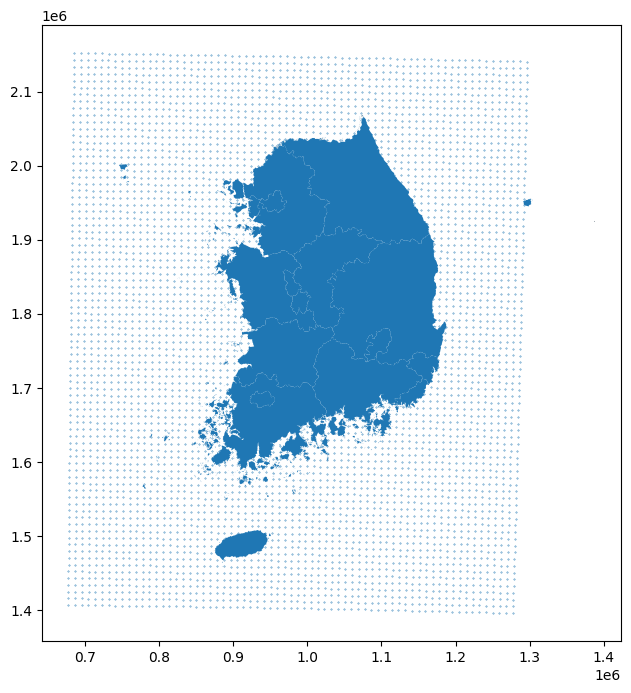

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
indexed_grid_point.to_crs(5179).plot(ax = ax, markersize = 0.1)
ctp_rvn_gpd.plot(ax = ax)

* 1*1 으로 82*67 중 도시부분만 피팅

In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [197]:
# 서울시만 피팅하는 버전 또는 바다 제거
results_pd = pd.DataFrame(columns=['id','train_mse','test_mse','train_rmse','test_rmse','train_r2','test_r2','x','y'])
# X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, np.mean(target_arr[:,x_start:x_end,y_start:y_end,:], axis = (1,2)), test_size=0.2, random_state=42 )
X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, target_arr, test_size=0.2, random_state=42 )
models = []


for pix_index in indexed_grid_point.loc[indexed_grid_point.CTP_KOR_NM == '경상북도'].index.tolist():
# for pix_index in indexed_grid_point.dropna().index.tolist():
    print(pix_index)
    x, y = pix_index%82,pix_index//82
    y_train_sub = y_train[:,x,y,:]
    y_test_sub = y_test[:,x,y,:]

    rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=50)
    rand_reg.fit(X_train, y_train_sub.ravel())
    models.append(rand_reg)
   
    y_pred_train = rand_reg.predict(X_train)
    y_pred = rand_reg.predict(X_test)

    train_mse = mean_squared_error(y_train_sub, y_pred_train, squared= True)
    test_mse = mean_squared_error(y_test_sub, y_pred, squared= True)

    train_rmse = mean_squared_error(y_train_sub, y_pred_train, squared= False)
    test_rmse = mean_squared_error(y_test_sub, y_pred, squared= False)

    train_r2 = r2_score(y_train_sub, y_pred_train,)
    test_r2 = r2_score(y_test_sub, y_pred,)

    results_pd.loc[pix_index,:] = [pix_index,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,x,y]
 

results_pd.loc[:,'model'] = models


3238
3239
3243
3244
3245
3246
3247
3248
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3647
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3727
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3809
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3891
3892
3893
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313


In [198]:
results_pd.head()

,id,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,x,y,model
3238,3238,0.025932,0.056154,0.161034,0.236968,0.798176,0.457558,40,39,"(DecisionTreeRegressor(max_depth=3, max_featur..."
3239,3239,0.027073,0.061908,0.16454,0.248814,0.797776,0.457651,41,39,"(DecisionTreeRegressor(max_depth=3, max_featur..."
3243,3243,0.037419,0.091374,0.193439,0.302281,0.799492,0.361307,45,39,"(DecisionTreeRegressor(max_depth=3, max_featur..."
3244,3244,0.0381,0.092721,0.195191,0.304501,0.802675,0.322145,46,39,"(DecisionTreeRegressor(max_depth=3, max_featur..."
3245,3245,0.037668,0.080286,0.194083,0.283348,0.80491,0.428159,47,39,"(DecisionTreeRegressor(max_depth=3, max_featur..."


<Axes: ylabel='Count'>

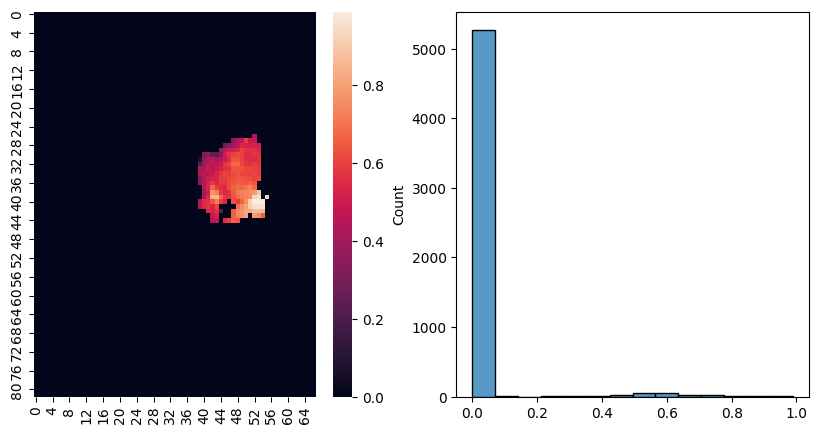

In [199]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_r2']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

<Axes: ylabel='Count'>

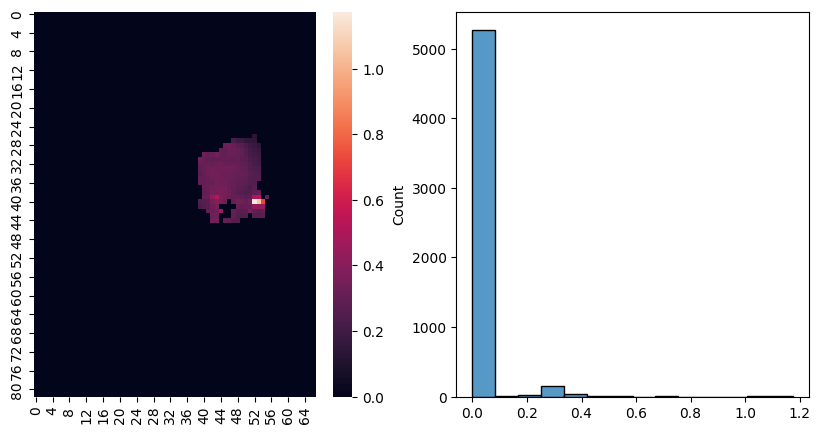

In [200]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_rmse']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

<Axes: ylabel='Count'>

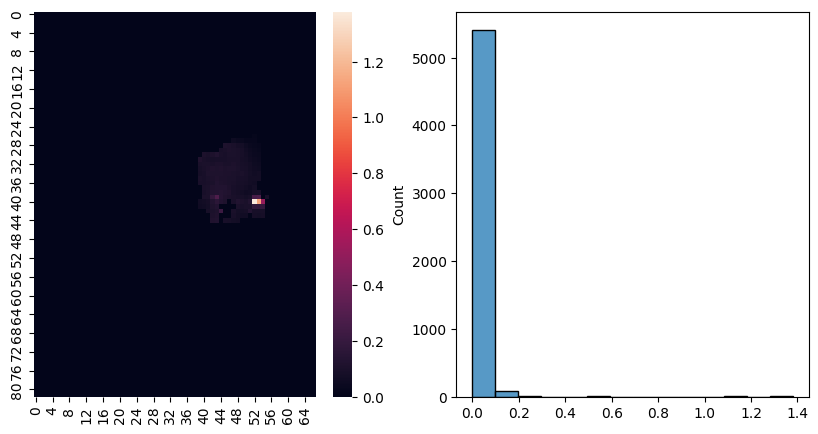

In [201]:
r2_map = np.zeros_like(target_arr[0])
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,['x', 'y', 'test_mse']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

In [224]:
pred_base = np.zeros_like(y_test)
for ind in results_pd.index.tolist():
    ind_val = results_pd.loc[ind,:].values
    pred = ind_val[9].predict(X_test)

    pred_base[:,ind_val[7],ind_val[8],0] = pred

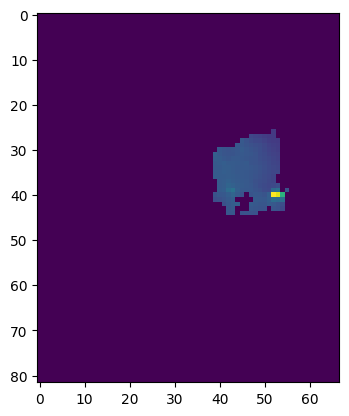

In [225]:
plt.imshow(pred_base[0][::-1])

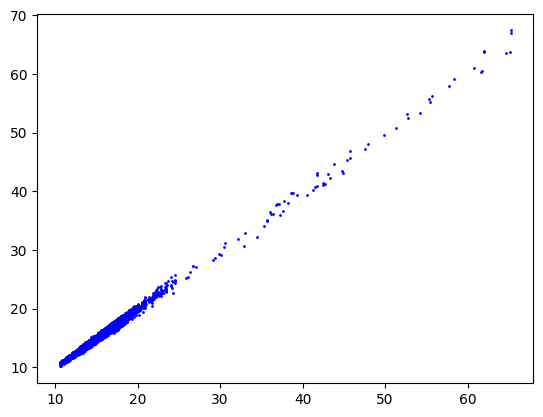

In [226]:
plt.plot(pred_base[pred_base != 0], y_test[pred_base != 0], 'bo', markersize = 1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_604\3062313336.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = [15,5])


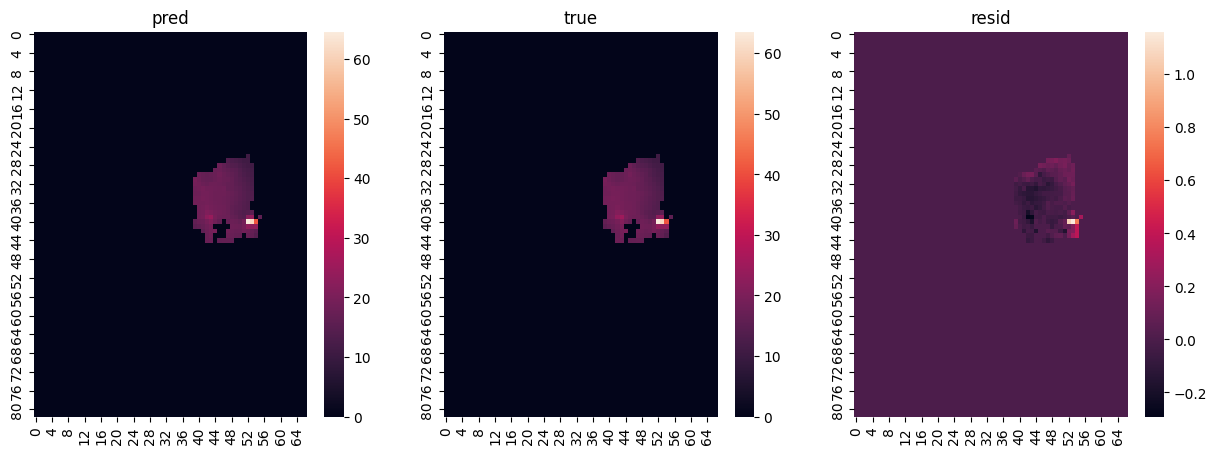

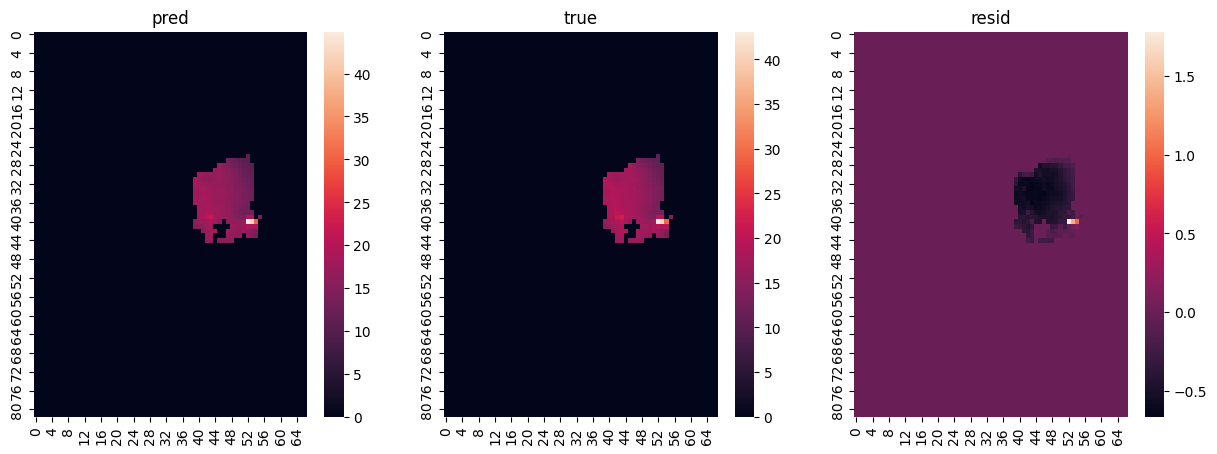

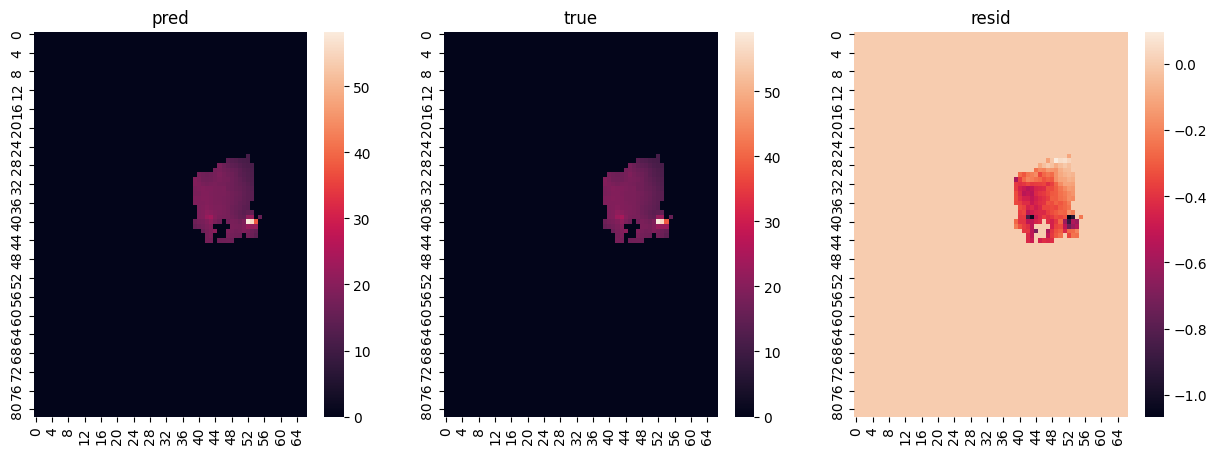

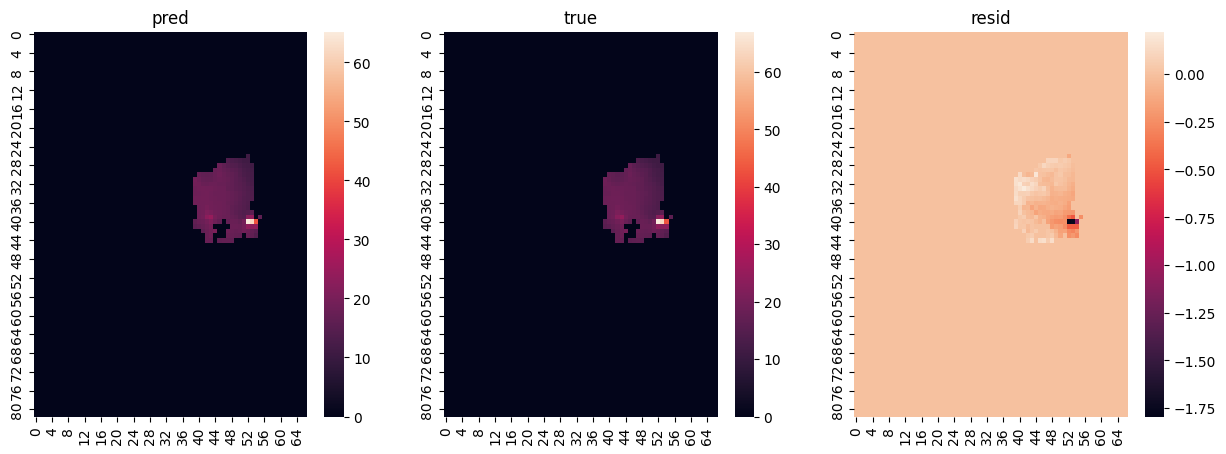

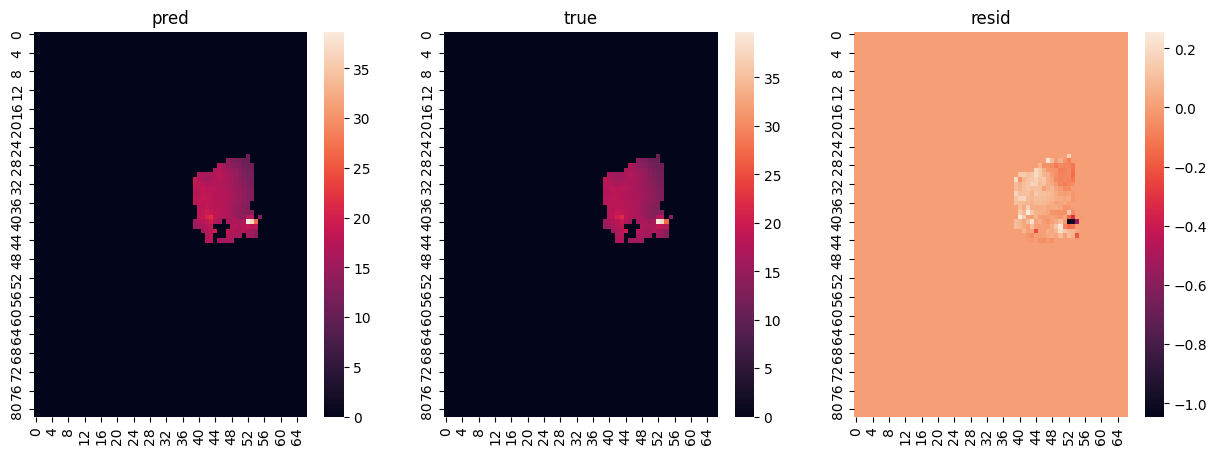

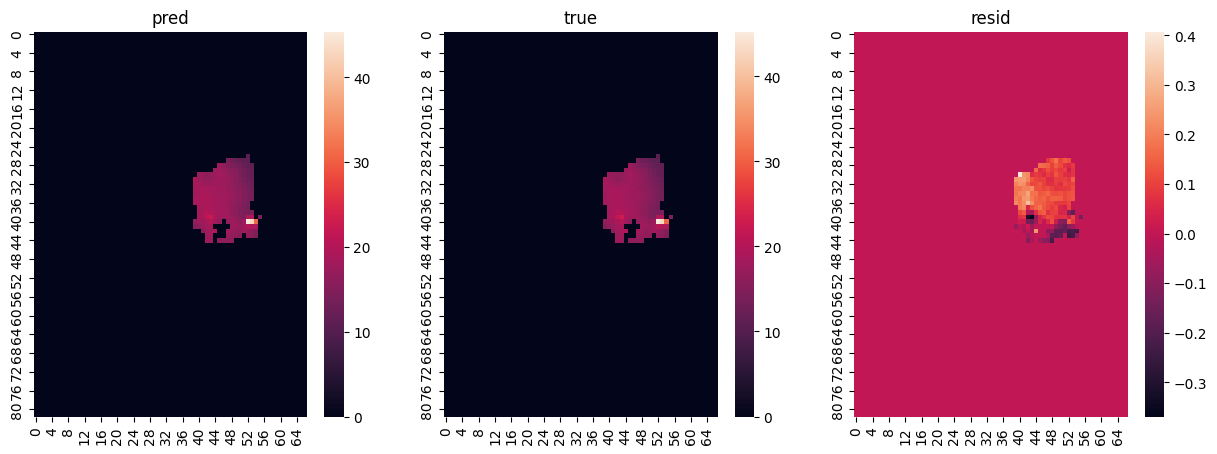

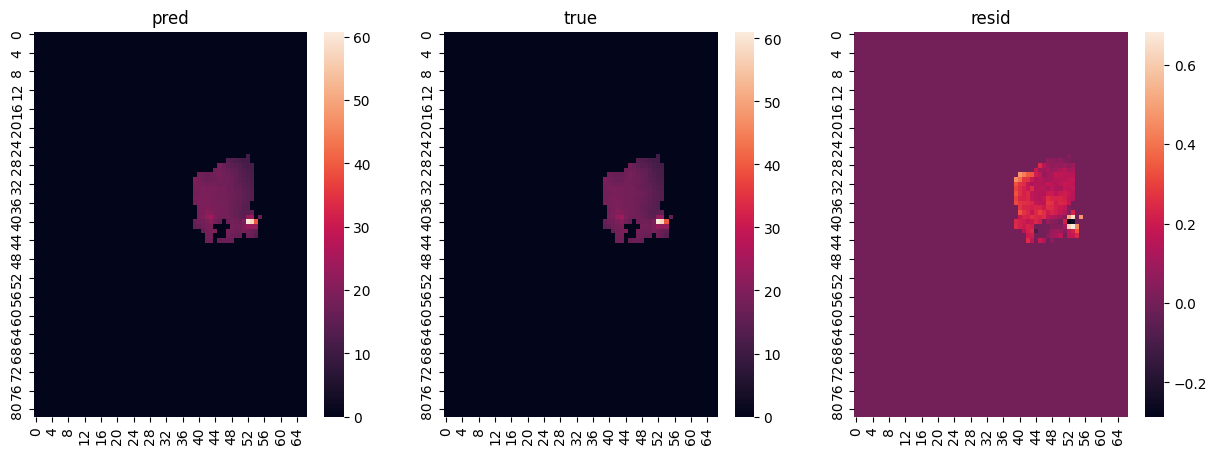

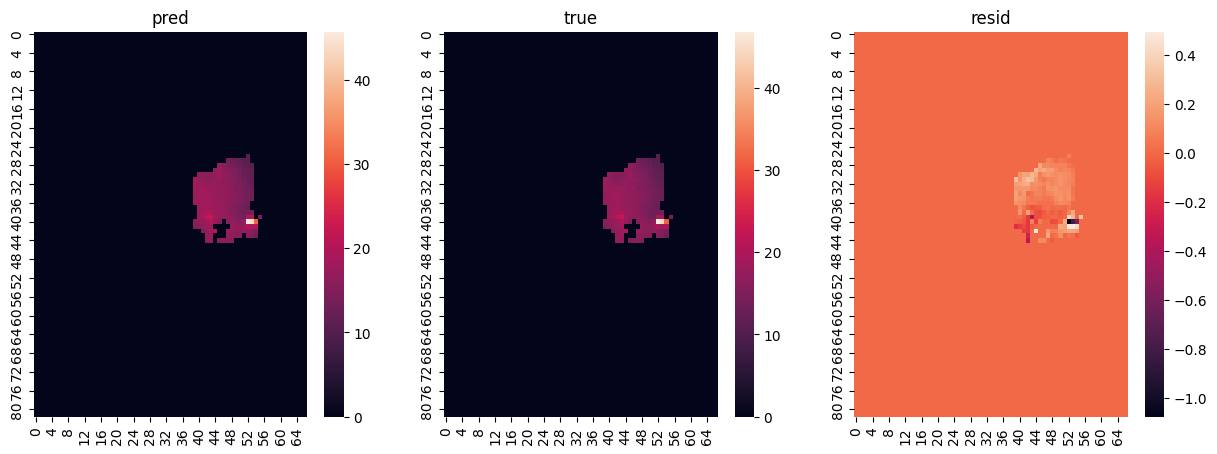

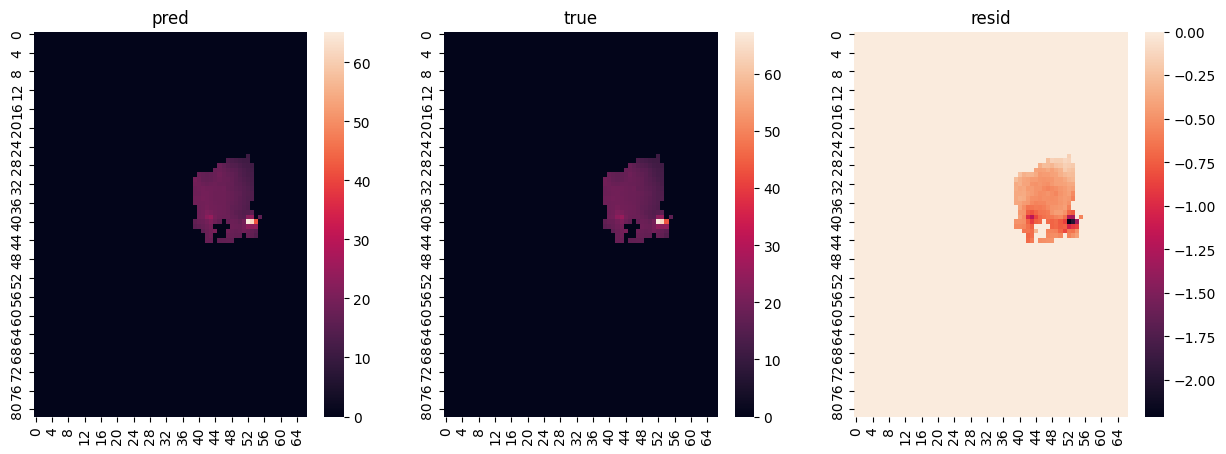

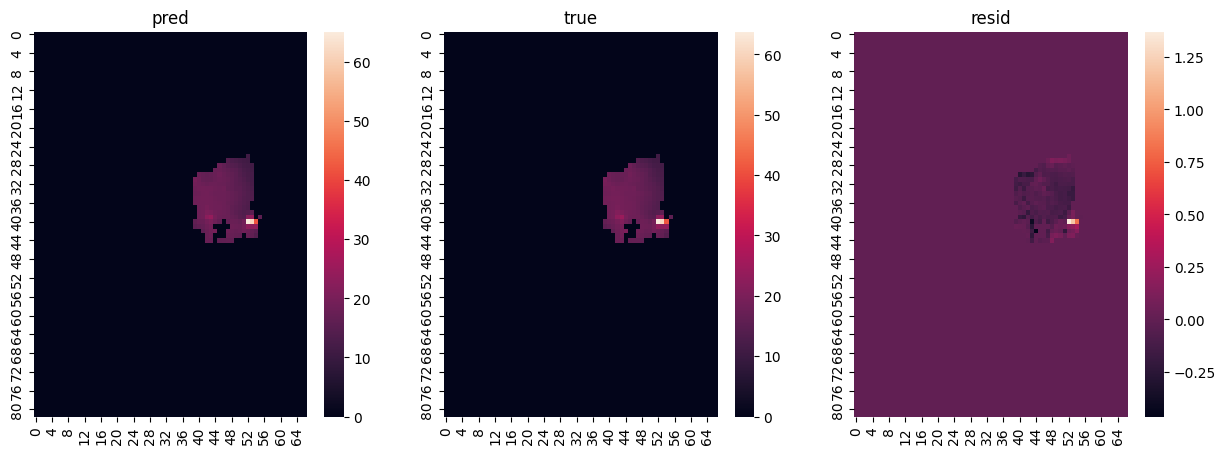

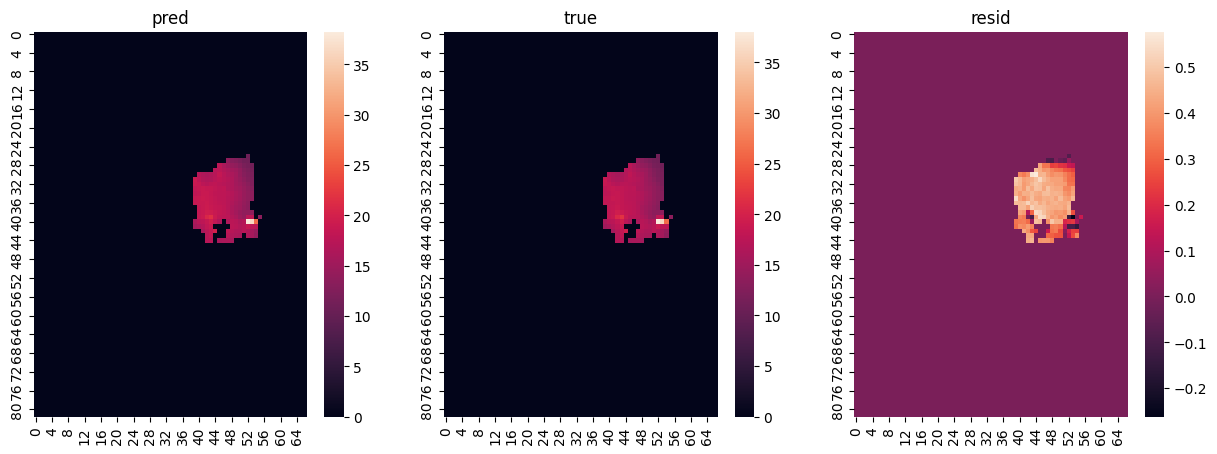

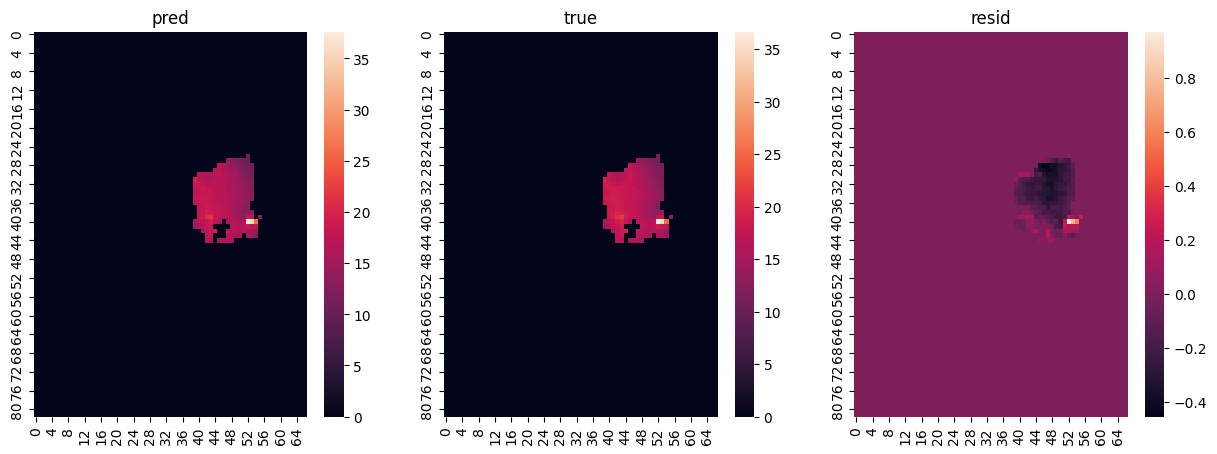

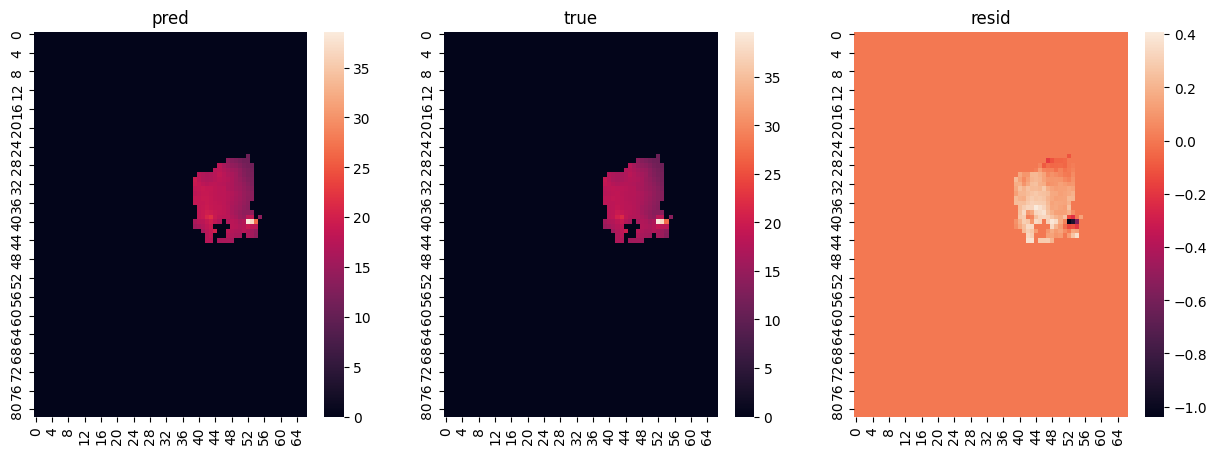

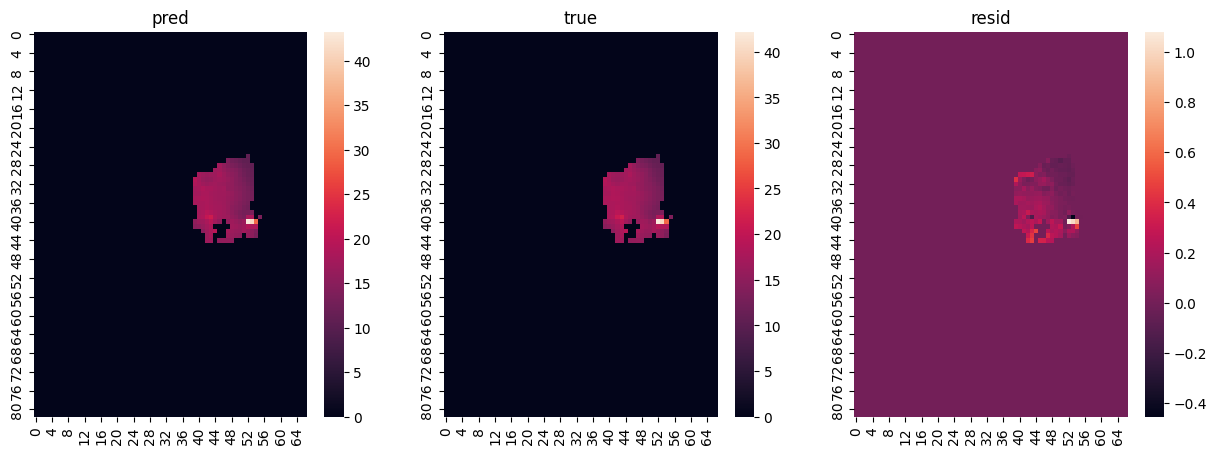

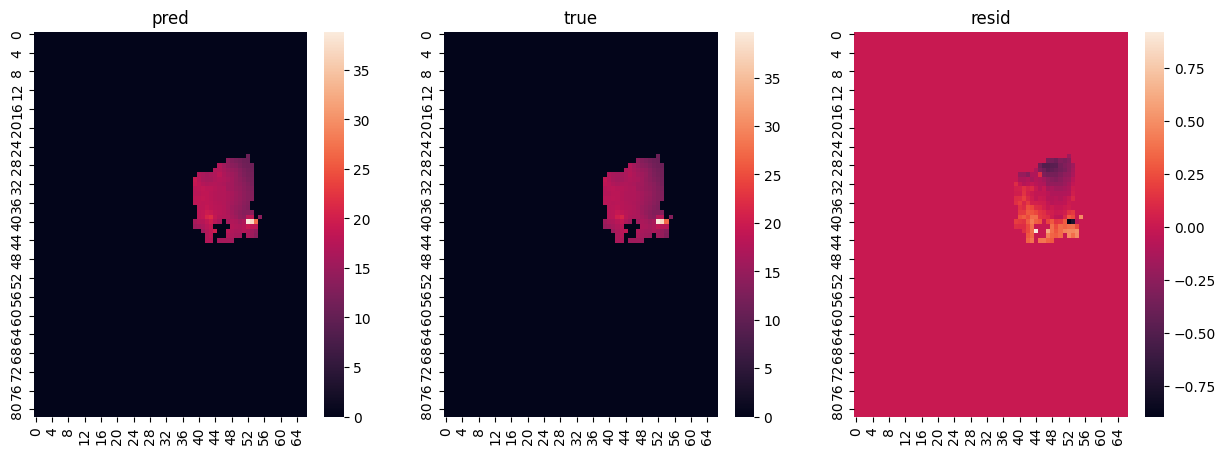

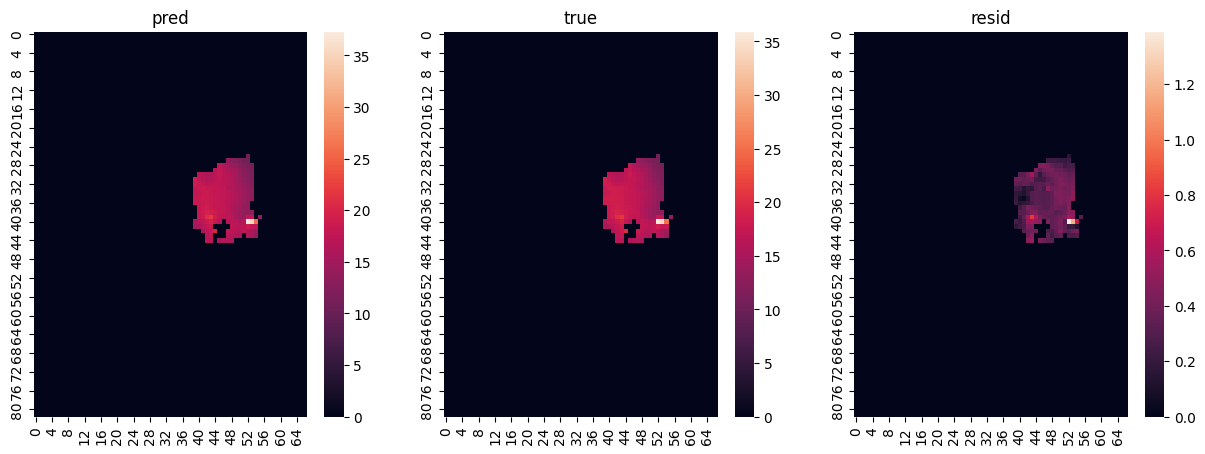

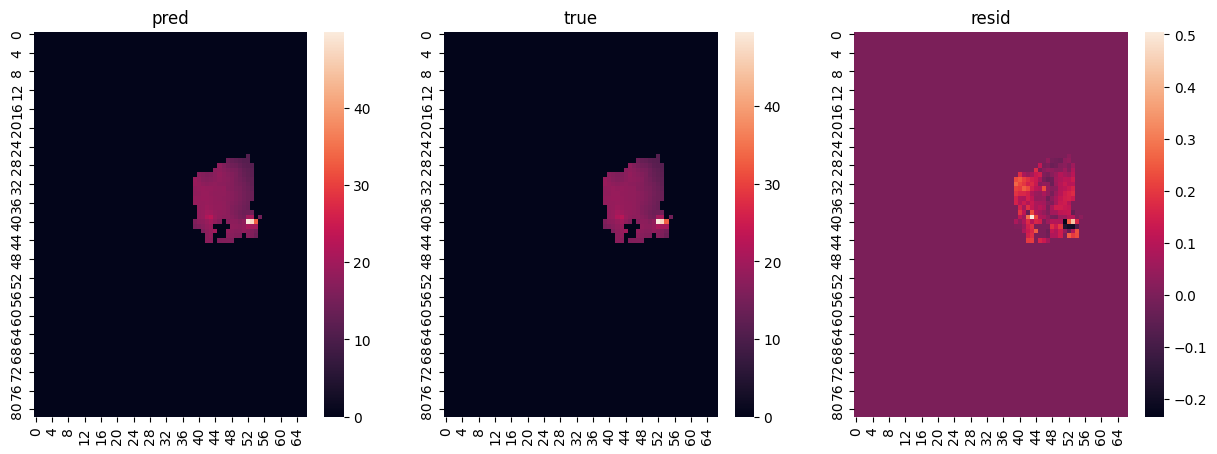

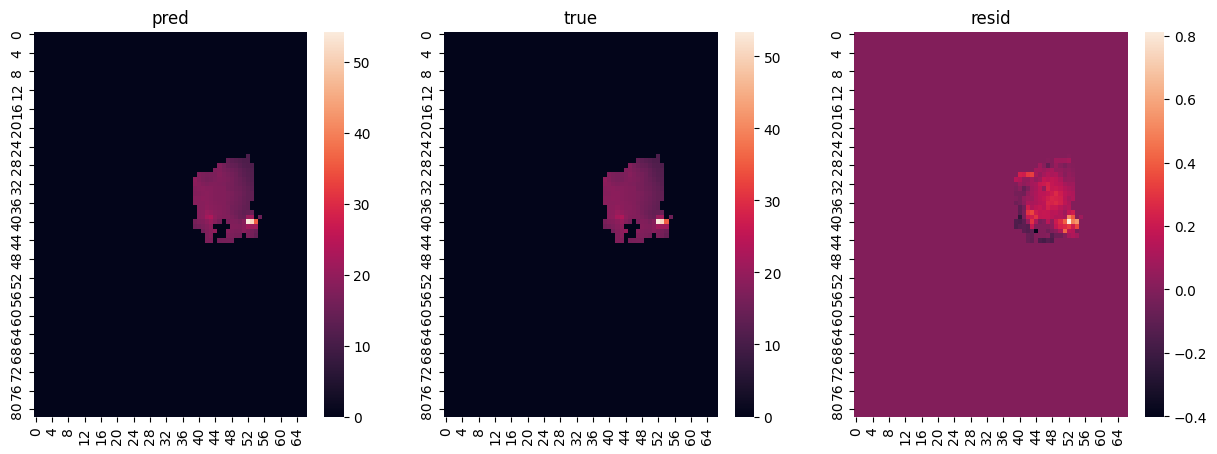

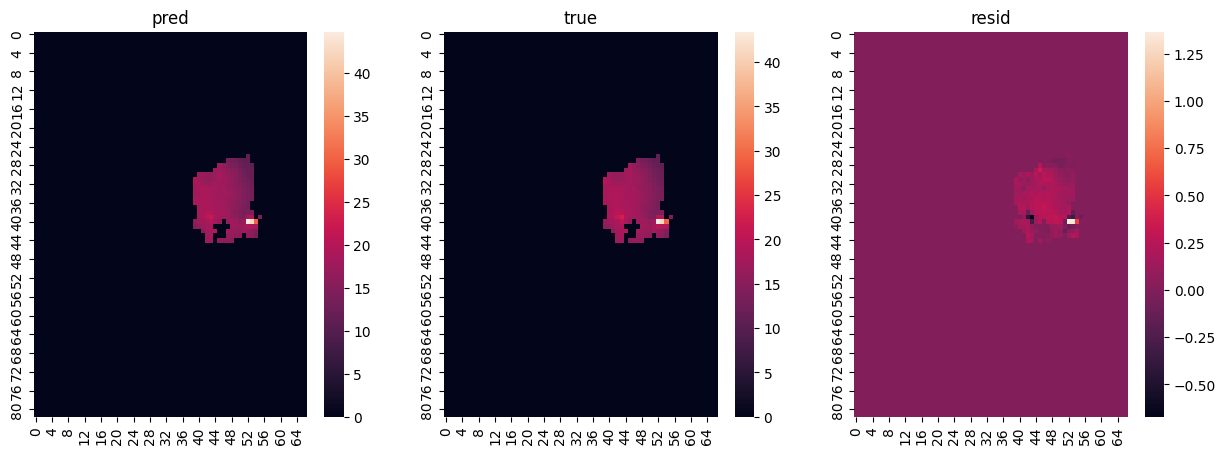

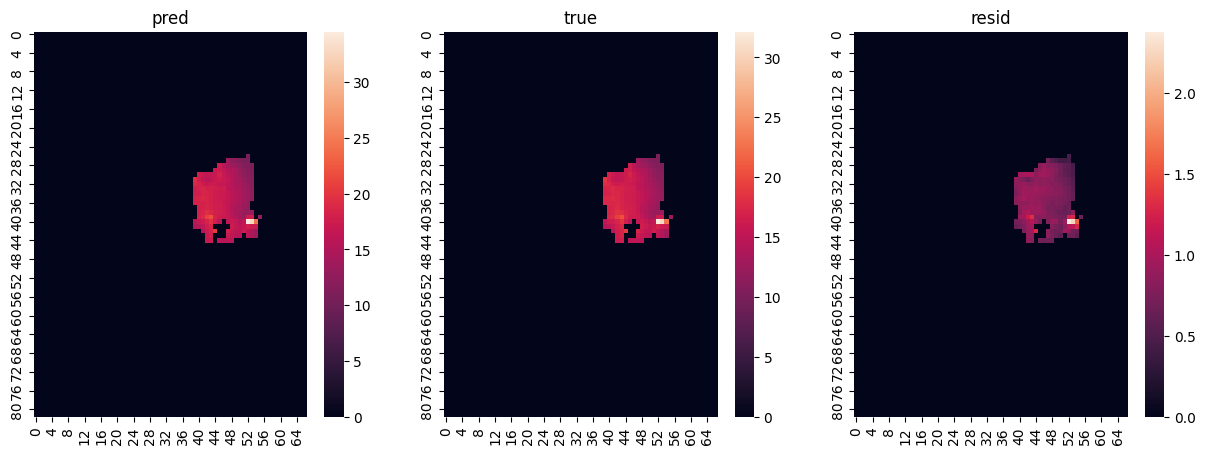

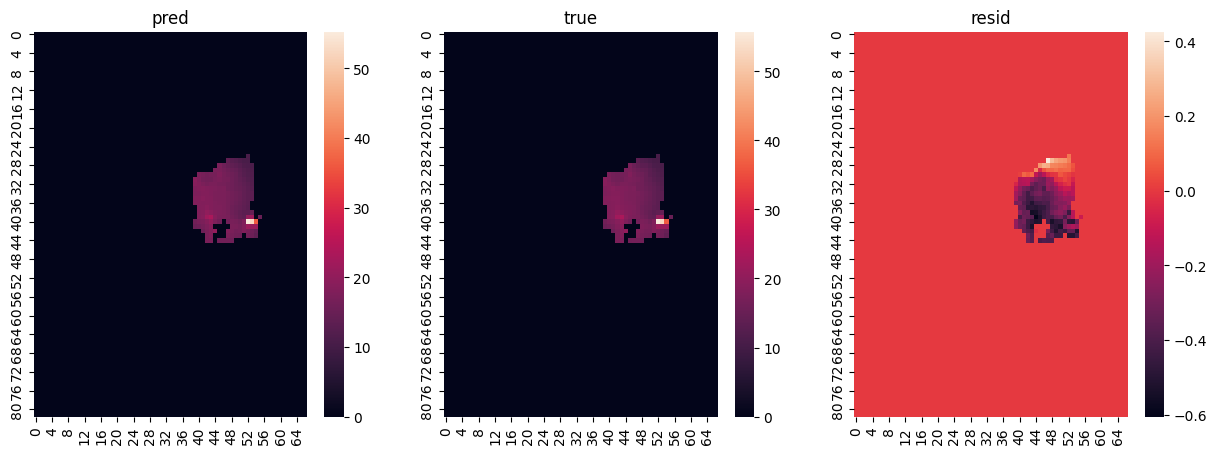

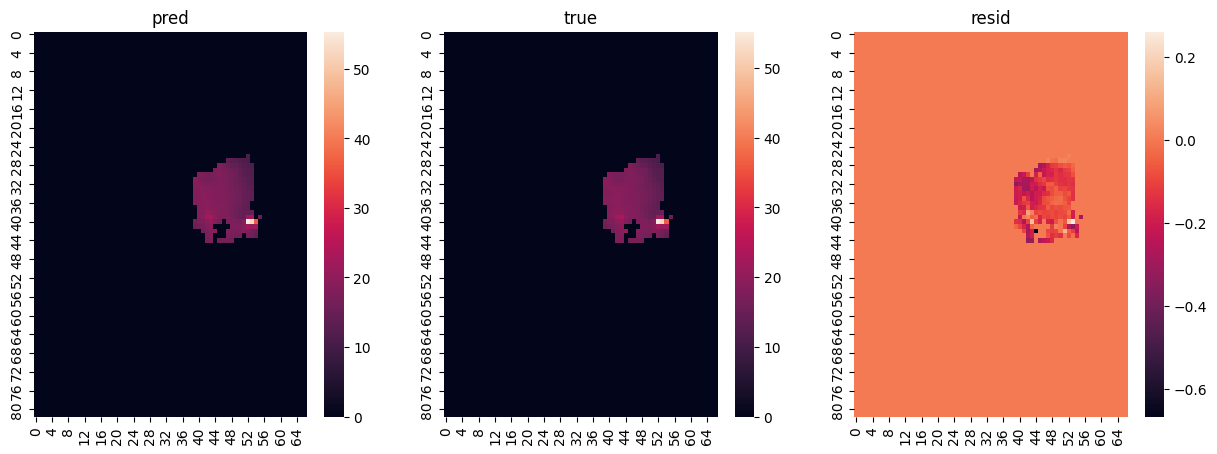

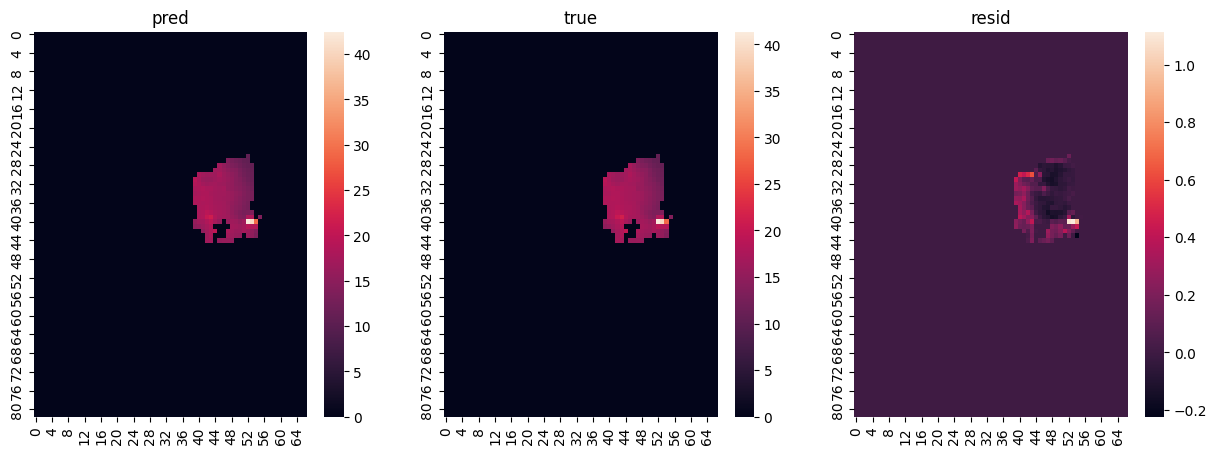

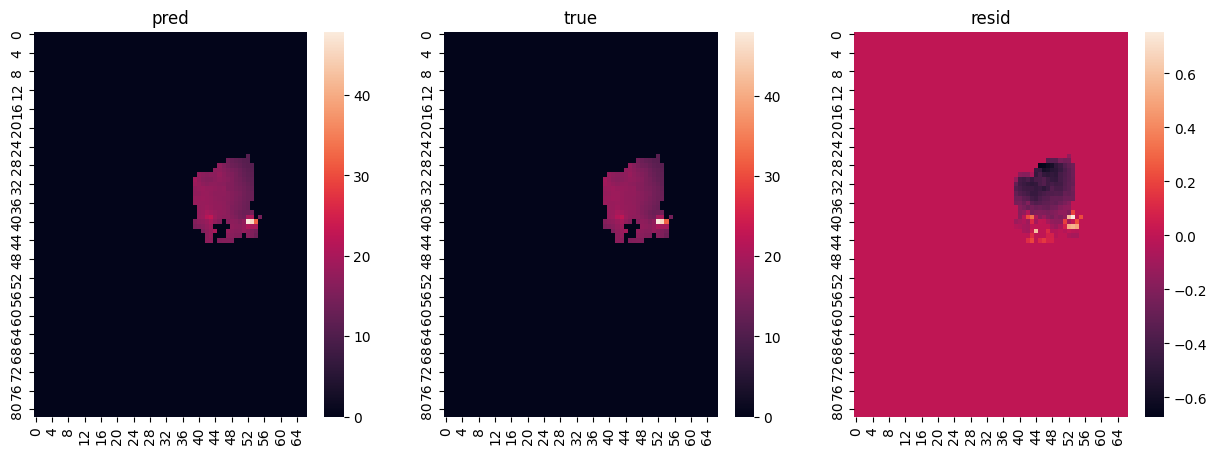

In [227]:
from copy import deepcopy
# asdasd
y_test_copy = deepcopy(y_test)
y_test_copy[np.where(pred_base == 0)] = 0 
for i in range(len(y_test_copy)):
    plt.figure(figsize = [15,5])
    plt.subplot(1,3,1)
    plt.title('pred')
    sns.heatmap(pred_base[i,:,:,0][::-1])
    plt.subplot(1,3,2)
    plt.title('true')
    sns.heatmap(y_test_copy[i,:,:,0][::-1])
    plt.subplot(1,3,3)
    plt.title('resid')
    sns.heatmap(pred_base[i,:,:,0][::-1] - y_test_copy[i,:,:,0][::-1])